# Example

## Spring network (diffusive formulation)

This example reformulates **Fish & Belytschko (2007), Example 2.2** using the **network-based diffusive framework**.

Although originally presented as a structural spring problem, it can be interpreted as a **pure diffusive system**, where:

* nodal displacements are the unknowns
* spring forces play the role of fluxes
* spring stiffness acts as element conductivity

<img src="images/barra4.svg" width="500">

## 1. Physical problem description

We consider a system of **linear springs** connecting four nodes.
Two nodal displacements are prescribed, and the remaining displacements are computed from equilibrium.

### Given data

* Spring stiffness:
$$
  k = 1
$$

* Prescribed displacements:
$$
  u_0 = 0, \quad u_1 = 10
$$

* No external forces at internal nodes:
$$
  f_2 = 0, \quad f_3 = 0
$$

---

## 2. Governing equations

### 2.1 Spring constitutive law

For a linear spring connecting nodes ( i ) and ( j ):

$$
F^{(e)} = k (u_i - u_j)
$$

This equation is **formally identical** to:

* hydraulic flow:
$$
  Q = k (H_i - H_j)
$$

* heat conduction:
$$
  q = k (T_i - T_j)
$$

Thus, the spring system is a **diffusive network**.

---

### 2.2 Element equilibrium matrix

For each spring element:

$$
\begin{bmatrix}
f_i^{(e)} \\
f_j^{(e)}
\end{bmatrix}
= k
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
\begin{bmatrix}
u_i \\
u_j
\end{bmatrix}
$$

---

## 3. Network interpretation

| Structural concept | Network abstraction |
| ------------------ | ------------------- |
| Displacement $u$   | Nodal unknown (`x`) |
| Force $f$          | Nodal source (`b`)  |
| Spring             | Edge                |
| Stiffness $k $     | `element_property`  |

---

## 4. Network definition

### 4.1 Create the network


In [1]:
import numpy as np
import netsystems as ns

In [2]:
net = ns.Network()

### 4.2 Connectivity

In [3]:
connectivity = np.array([
    [0, 3],
    [3, 1],
    [0, 2],
    [3, 2],
    [2, 1],
])

net.set_connectivity(connectivity)

This network has:

* 4 nodes
* 5 spring elements
* multiple alternative paths between nodes

---

## 5. Structural system as a diffusive system

### 5.1 System definition

In [4]:
structure = ns.System("structure", system_type="diffusive")

structure.x_name = "nodal_displacement"
structure.b_name = "nodal_force"
structure.element_variable_name = "spring_force"

### 5.2 Boundary conditions

#### Prescribed displacements 

$$
u_0 = 0, \quad u_1 = 10
$$

In [5]:
structure.known_x_nodes = np.array([0, 1])
structure.known_x_values = np.array([0.0, 10.0])

#### Prescribed nodal forces

$$
f_2 = 0, \quad f_3 = 0
$$

In [6]:
structure.known_b_nodes = np.array([2, 3])
structure.known_b_values = np.array([0.0, 0.0])

## 6. Element stiffness (`element_property`)

All springs have the same stiffness:

$$
k^{(e)} = 1
$$

In [7]:
structure.element_conductance = np.ones(net.n_elements, dtype=float)

Here, `element_property` represents the **spring stiffness**, playing the same role as:

* hydraulic conductivity
* thermal conductance
* axial bar stiffness

## 7. Assembly and solution

### 7.1 Add system to the network

In [8]:
net.add_system(structure)

### 7.2 Solve the system

In [9]:
ns.solve_linear_system(net, "structure")

0

This performs:

1. Element stiffness assembly
2. Global matrix construction
3. Boundary condition enforcement
4. Linear solution of the system

## 8. Extracting results

### 8.1 Nodal displacements

In [10]:
net.get("nodal_displacement")

array([ 0., 10.,  5.,  5.])

This returns the displacement at all nodes, including the unknown internal nodes.

---

### 8.2 Nodal forces (including reactions)

In [11]:
net.get("nodal_force")

array([-10.,  10.,   0.,   0.])

Reaction forces will appear at nodes 0 and 1 due to the imposed displacements.

---

### 8.3 Spring forces

In [12]:
net.get("spring_force")

array([-5., -5., -5.,  0., -5.])

Each value corresponds to:

$$
F^{(e)} = k (u_i - u_j)
$$

for the corresponding element.

---

## 9. Global stiffness matrix

### 9.1 Obtain sparse matrix

In [13]:
K = ns.get_global_matrix_csr(net, "structure")
print(K.todense())

[[ 2.  0. -1. -1.]
 [ 0.  2. -1. -1.]
 [-1. -1.  3. -1.]
 [-1. -1. -1.  3.]]


This is the **global stiffness matrix** of the spring network.

---

### 9.2 Visualize sparsity pattern

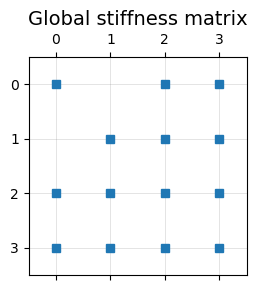

(<Figure size 300x300 with 1 Axes>,
 <Axes: title={'center': 'Global stiffness matrix'}>)

In [14]:
ns.spy_matrix(
    K,
    title="Global stiffness matrix",
    markersize=6,
    figsize=(3, 3)
)